### Installing Required Libraries

This cell installs all the Python packages required for the stock prediction and reinforcement learning project.

**Installed Packages:**
- **yfinance**: Fetches historical stock data from Yahoo Finance.
- **pandas**: Provides DataFrames and tools for handling tabular data.
- **numpy**: Supports numerical computations and array operations.
- **matplotlib**: Used for plotting charts and visualizing data.
- **torch**: PyTorch library for building and training deep learning models.
- **transformers**: Hugging Face library for pretrained Transformer models (for NLP tasks like sentiment analysis).
- **accelerate**: Optimizes distributed and mixed-precision training with Transformers.
- **scikit-learn**: Provides ML utilities like scaling, metrics, and model evaluation.
- **tqdm**: Adds progress bars for loops to monitor long-running computations.
- **vaderSentiment** (optional): Lightweight sentiment analysis tool for quickly analyzing news or text.

**Notes:**
- `-q` flag suppresses installation messages for a cleaner notebook output.
- Versions are pinned (e.g., `>=0.2.40`) to ensure compatibility and reproducibility.
- `vaderSentiment` is optional but can greatly speed up sentiment analysis during testing.


In [1]:
# 1) Installs (quiet + pinned for stability)
!pip -q install "yfinance>=0.2.40" "pandas>=2.2.2" "numpy>=1.26.4" "matplotlib>=3.8.4" \
                "torch>=2.2.2" "transformers>=4.41.0" "accelerate>=0.30.0" \
                "scikit-learn>=1.4.2" "tqdm>=4.66.4"

# Optional (MUCH faster sentiment in quick tests):
!pip -q install "vaderSentiment>=3.3.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


### Installing Reinforcement Learning Libraries

This cell installs key libraries required for building and training reinforcement learning (RL) agents.

**Installed Packages:**
- **gymnasium==0.29.1**: Provides environments for reinforcement learning. It allows us to simulate stock trading or other RL tasks.
- **shimmy==1.3.0**: A helper library that ensures compatibility between different Gym environments and RL frameworks.
- **stable-baselines3==2.3.0**: Implements popular RL algorithms like PPO (Proximal Policy Optimization), DQN, and A2C in a reliable and easy-to-use way.

**Notes:**
- Versions are explicitly pinned to ensure **compatibility and reproducibility** with other libraries like PyTorch and Gymnasium.
- These libraries are essential for creating a custom stock trading environment and training RL agents efficiently.


In [2]:
!pip install gymnasium==0.29.1 shimmy==1.3.0 stable-baselines3==2.3.0

Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


### Setup & Configuration (Multi-Ticker)

This cell sets up the environment, imports all required libraries, mounts Google Drive, creates project folders, and defines the global configuration for the stock prediction and reinforcement learning project.

**Key Steps:**

1. **Library Imports:**
   - **System & Utilities:** `os`, `random`, `math`, `datetime`, `warnings`, `json`, `gc`.
   - **Data Handling & Visualization:** `numpy`, `pandas`, `matplotlib`.
   - **Deep Learning:** `torch`, `torch.nn`, `torch.utils.data` for PyTorch models and custom datasets.
   - **Preprocessing & ML:** `StandardScaler`, `MinMaxScaler`, `train_test_split`.
   - **Progress Bars:** `tqdm`.
   - **Stock Data:** `yfinance`.
   - **NLP/Transformers:** Hugging Face `transformers` for FinBERT sentiment analysis.
   - **Reinforcement Learning:** `gymnasium`, `stable_baselines3.PPO`.

2. **Google Drive Mounting & Folder Setup:**
   - Mounts Google Drive to `/content/drive`.
   - Creates project directories


In [3]:
# Cell 1: Setup & Config (Multi-Ticker)

import os, random, math, datetime as dt, warnings, json, gc
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import yfinance as yf

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

# Mount Drive & create project folders
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/stock_rl_transformer"
DATA_DIR    = f"{PROJECT_DIR}/data"
CACHE_DIR   = f"{PROJECT_DIR}/cache"
MODELS_DIR  = f"{PROJECT_DIR}/models"
PLOTS_DIR   = f"{PROJECT_DIR}/plots"

for d in [PROJECT_DIR, DATA_DIR, CACHE_DIR, MODELS_DIR, PLOTS_DIR]:
    os.makedirs(d, exist_ok=True)

# Global config
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL"],  # multiple tickers
    "start": "2015-01-01",
    "end": dt.date.today().isoformat(),
    "seq_len": 60,
    "test_size": 0.2,
    "val_size": 0.1,
    "quick_run": False,
    "finbert": True,
    "max_headlines_per_day": 30,
    "transformer": {
        "epochs": 3 if True else 12,
        "batch_size": 64,
        "lr": 2e-4,
        "d_model": 64,
        "nhead": 4,
        "num_layers": 2,
        "dim_feedforward": 128,
        "dropout": 0.3 # Increased dropout
    },
    "ppo": {
        "timesteps": 20_000 if True else 150_000,
        "learning_rate": 1e-4,
        "gamma": 0.99,
        "ent_coef": 0.001,
        "vf_coef": 0.5,
        "clip_range": 0.2,
        "n_steps": 4096,
        "batch_size": 128,
        "n_epochs": 10
    },
    "fees_bps": 1.0,
    "seed": 42
}

# Seed everything
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(CONFIG["seed"])

# Utility logger
def log(msg): print(f"[{dt.datetime.now().strftime('%H:%M:%S')}] {msg}")

log("Setup complete. Drive mounted, folders created, config loaded.")

# Note: Later cells will loop over CONFIG['tickers'] to fetch data, compute features, train models, etc.

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

Mounted at /content/drive
[06:30:43] Setup complete. Drive mounted, folders created, config loaded.


### Downloading Prices & Computing Technical Indicators (Multi-Ticker)

This cell fetches historical OHLCV (Open, High, Low, Close, Volume) data for multiple tickers using `yfinance` and computes various financial features and technical indicators to be used as model inputs.

**Steps and Key Features:**

1. **Download Historical Data:**
   - Loops over `CONFIG['tickers']` and fetches adjusted stock prices from Yahoo Finance.
   - Columns are standardized to `['Open','High','Low','Close','Volume']`.
   - Data is filtered if `quick_run=True` to limit to the last 5 years.

2. **Basic Returns:**
   - `Return`: Daily percentage change of the close price.
   - `LogRet`: Log returns (`log1p(Return)`) for stability in calculations.

3. **Lagged Returns:**
   - `LogRet_1d`: Previous day’s log return.
   - `LogRet_5d`: 5-day rolling sum of log returns.
   - `LogRet_10d`: 10-day rolling sum of log returns.

4. **Volatility Features:**
   - `Volatility_5d` and `Volatility_10d`: Rolling standard deviation of log returns.

5. **Normalized Volume:**
   - `Vol_norm`: Current volume normalized by the 20-day rolling average.

6. **Momentum Features:**
   - `Price_vs_SMA20` and `Price_vs_SMA50`: Ratio of current price to 20-day and 50-day simple moving averages (SMA), indicating trend strength.

7. **Custom Indicator Functions:**
   - `EMA(series, span)`: Exponential Moving Average.
   - `RSI(close, period)`: Relative Strength Index for momentum.
   - `MACD(close)`: Moving Average Convergence Divergence and signal line.
   - `BBANDS(close)`: Bollinger Bands width as a measure of volatility.

8. **Computed Indicators Added to DataFrame:**
   - `SMA_10`, `SMA_20`, `EMA_12`, `EMA_26`
   - `RSI_14`, `MACD`, `MACD_S` (signal), `MACD_H` (histogram)
   - `BB_Width`: Bollinger Bands width
   - `HL_Range`: Daily high-low range relative to close
   - `Volume_Change`: Daily percentage change in volume
   - `Ticker`: Adds ticker symbol for multi-ticker identification

9. **Data Aggregation:**
   - Stores individual ticker DataFrames in `all_data`.
   - Optionally, combines all tickers into `df_all` for unified processing.

**Notes:**
- Dropping `NaN` values ensures clean data for model training.
- These features provide both price-based and volatility-based information for the Transformer and RL models.
- Logging statements track download progress and dataset size per ticker.


In [4]:
# Cell 2: Prices & Indicators (Multi-Ticker)

log("Downloading OHLCV for multiple tickers with yfinance...")

all_data = {}  # dictionary to store df per ticker

for ticker in CONFIG['tickers']:   # <-- corrected key name
    log(f"Fetching {ticker}...")
    df = yf.download(ticker, start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)
    df = df.rename(columns=str.title)[['Open','High','Low','Close','Volume']].dropna().copy()
    df.index.name = "Date"

    if CONFIG["quick_run"]:
        cutoff = df.index.max() - pd.Timedelta(days=365*5)
        df = df[df.index >= cutoff].copy()

    # Basic returns
    df['Return'] = df['Close'].pct_change()
    df['LogRet'] = np.log1p(df['Return'])

    # === Lagged returns ===
    df['LogRet_1d'] = df['LogRet'].shift(1)
    df['LogRet_5d'] = df['LogRet'].rolling(5).sum()
    df['LogRet_10d'] = df['LogRet'].rolling(10).sum()

    # === Volatility features ===
    df['Volatility_5d'] = df['LogRet'].rolling(5).std()
    df['Volatility_10d'] = df['LogRet'].rolling(10).std()


    # === Normalized volume ===
    df['Vol_norm'] = df['Volume'] / df['Volume'].rolling(20).mean()

    # === Momentum (price relative to moving average) ===
    df['Price_vs_SMA20'] = df['Close'] / df['Close'].rolling(20).mean()
    df['Price_vs_SMA50'] = df['Close'] / df['Close'].rolling(50).mean()


    # Indicators
    def EMA(series, span):
        return series.ewm(span=span, adjust=False).mean()

    def RSI(close, period=14):
        delta = close.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ma_up = up.rolling(period).mean()
        ma_down = down.rolling(period).mean()
        rs = ma_up / (ma_down + 1e-12)
        return 100 - (100 / (1 + rs))

    def MACD(close, fast=12, slow=26, signal=9):
        ema_fast = EMA(close, fast)
        ema_slow = EMA(close, slow)
        macd = ema_fast - ema_slow
        sig = EMA(macd, signal)
        hist = macd - sig
        return macd, sig, hist

    def BBANDS(close, window=20, nstd=2):
        ma = close.rolling(window).mean()
        sd = close.rolling(window).std()
        upper = ma + nstd*sd
        lower = ma - nstd*sd
        width = (upper - lower) / (ma + 1e-12)
        return upper, lower, width

    # Compute indicators
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['EMA_12'] = EMA(df['Close'], 12)
    df['EMA_26'] = EMA(df['Close'], 26)
    df['RSI_14'] = RSI(df['Close'], 14)
    macd, macds, macdh = MACD(df['Close'])
    df['MACD'] = macd; df['MACD_S'] = macds; df['MACD_H'] = macdh
    bb_u, bb_l, bb_w = BBANDS(df['Close'])
    df['BB_Width'] = bb_w
    df['HL_Range'] = (df['High'] - df['Low']) / (df['Close'] + 1e-12)
    df['Volume_Change'] = df['Volume'].pct_change()

    df = df.dropna().copy()
    df['Ticker'] = ticker
    all_data[ticker] = df
    log(f"{ticker} -> {len(df)} rows, {df.index.min().date()} to {df.index.max().date()}")

# Optional: combine all tickers into a single DataFrame
df_all = pd.concat(all_data.values()).sort_index()
log(f"All tickers combined: {len(df_all)} rows.")

[06:30:50] Downloading OHLCV for multiple tickers with yfinance...
[06:30:50] Fetching AAPL...
[06:30:51] AAPL -> 2646 rows, 2015-03-16 to 2025-09-19
[06:30:51] Fetching MSFT...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:30:52] MSFT -> 2646 rows, 2015-03-16 to 2025-09-19
[06:30:52] Fetching GOOGL...
[06:30:52] GOOGL -> 2646 rows, 2015-03-16 to 2025-09-19
[06:30:52] All tickers combined: 7938 rows.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Sentiment Analysis (FinBERT) with Caching - Multi-Ticker

This section computes daily sentiment scores from news headlines and merges them with stock price data. It uses FinBERT for financial sentiment analysis but can fall back to VADER for faster testing.

**Steps and Key Features:**

1. **Reading News CSV:**
   - `read_news_csv(path)` reads a CSV file containing news headlines.
   - Handles multiple CSV schemas:
     - Columns like `Top1`, `Top2`, … are melted into `Date`-`headline` pairs.
     - If already in `Date` and `headline` format, uses them directly.
   - Ensures all headlines are strings and trims whitespace.
   - Converts `Date` to `datetime.date` format.

2. **Computing Sentiment:**
   - `compute_sentiment(df_news, df_prices)` calculates daily sentiment scores aligned with price data.
   - Filters news within a few days of the price data range.
   - If `quick_run` is enabled, limits to `max_headlines_per_day` for faster processing.
   - **FinBERT Mode (`CONFIG["finbert"]=True`)**:
     - Loads Hugging Face FinBERT model and tokenizer.
     - Classifies headlines as positive (+1), neutral (0), or negative (-1), weighted by model confidence.
   - **VADER Mode (Fallback)**:
     - Uses `vaderSentiment`’s compound score for each headline.
   - Aggregates headline scores per day using the mean to get `daily sentiment`.

3. **Caching Sentiment:**
   - Checks if sentiment for a ticker exists in `CACHE_DIR`.
   - If cached, loads sentiment to avoid recomputation.
   - Otherwise, computes sentiment and saves it as a Parquet file for future runs.

4. **Aligning Sentiment with Prices:**
   - Reindexes daily sentiment to match trading days in `all_data[ticker]`.
   - Uses forward fill and fills missing days with `0.0`.
   - Adds a `Sentiment` column to the price DataFrame.

**Notes:**
- Caching drastically speeds up repeated runs.
- Daily sentiment captures market mood and serves as an additional feature for Transformer and PPO models.
- Logging statements provide feedback on loaded rows, computation, and merging progress.


In [5]:
# Cell 3: Sentiment (FinBERT) with Cache - Multi-Ticker

# Path to news CSV
NEWS_FILE_NAME = "Combined_News_DJIA.csv"
NEWS_CSV = os.path.join(DATA_DIR, NEWS_FILE_NAME)

def read_news_csv(path):
    if not os.path.exists(path):
        log(f"ERROR: {path} not found. Please place your file in {DATA_DIR}.")
        return pd.DataFrame(columns=["Date","headline"])

    df_news = pd.read_csv(path, encoding="utf-8", engine="python")

    if "Date" in df_news.columns and any(c.lower().startswith("top") for c in df_news.columns):
        head_cols = [c for c in df_news.columns if c.lower().startswith("top")]
        df_m = df_news.melt(id_vars="Date", value_vars=head_cols, var_name="rank", value_name="headline")
    elif {"Date","headline"}.issubset(df_news.columns):
        df_m = df_news[["Date","headline"]]
    else:
        txt_cols = [c for c in df_news.columns if c.lower() not in ["date","label"]]
        if "Date" not in df_news.columns or not txt_cols:
            log("Unrecognized news CSV schema. Using empty news.")
            return pd.DataFrame(columns=["Date","headline"])
        df_m = df_news.melt(id_vars="Date", value_vars=txt_cols, var_name="src", value_name="headline")

    df_m = df_m.dropna(subset=["headline"])
    df_m["Date"] = pd.to_datetime(df_m["Date"]).dt.tz_localize(None).dt.date
    df_m["headline"] = df_m["headline"].astype(str).str.strip()
    return df_m

def compute_sentiment(df_news, df_prices):
    if df_news.empty:
        return pd.DataFrame({"Date": pd.to_datetime(df_prices.index).date, "sentiment": 0.0}).drop_duplicates("Date")

    dmin, dmax = df_prices.index.min().date(), df_prices.index.max().date()
    df_news = df_news[(df_news["Date"] >= dmin - dt.timedelta(days=3)) & (df_news["Date"] <= dmax + dt.timedelta(days=3))].copy()

    if CONFIG["quick_run"] and CONFIG["max_headlines_per_day"]:
        df_news["rank"] = df_news.groupby("Date").cumcount()
        df_news = df_news[df_news["rank"] < CONFIG["max_headlines_per_day"]].drop(columns="rank")

    if CONFIG["finbert"]:
        log("Loading FinBERT...")
        tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
        mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
        clf = pipeline("text-classification", model=mdl, tokenizer=tok, truncation=True, max_length=128, device=-1)
        label_map = {"positive": 1.0, "neutral": 0.0, "negative": -1.0}

        scores = []
        texts = df_news["headline"].tolist()
        for out in tqdm(clf(texts, batch_size=32), total=len(texts)):
            scores.append(label_map.get(out["label"].lower(), 0.0) * float(out.get("score", 1.0)))
        df_news["sent"] = scores
    else:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        vs = SentimentIntensityAnalyzer()
        df_news["sent"] = df_news["headline"].map(lambda x: vs.polarity_scores(str(x))["compound"])

    daily = df_news.groupby("Date")["sent"].mean().reset_index().rename(columns={"sent":"sentiment"})
    return daily

# Process each ticker
all_sent = {}
for ticker in CONFIG['tickers']:
    SENT_CACHE = os.path.join(CACHE_DIR, f"sentiment_{ticker}.parquet")

    df_prices = all_data[ticker]  # price df for this ticker

    if os.path.exists(SENT_CACHE):
        news_daily = pd.read_parquet(SENT_CACHE)
        news_daily["Date"] = pd.to_datetime(news_daily["Date"]).dt.date
        log(f"[{ticker}] Loaded sentiment from cache: {SENT_CACHE} ({len(news_daily)} days).")
    else:
        news_df = read_news_csv(NEWS_CSV)
        log(f"[{ticker}] Loaded raw news rows: {len(news_df)}.")
        news_daily = compute_sentiment(news_df, df_prices)
        os.makedirs(CACHE_DIR, exist_ok=True)
        news_daily.to_parquet(SENT_CACHE, index=False)
        log(f"[{ticker}] Computed & cached sentiment to {SENT_CACHE}.")

    # Align with trading days
    sent_series = pd.Series(news_daily.set_index(pd.to_datetime(news_daily["Date"]))["sentiment"])
    sent_series.index = sent_series.index.tz_localize(None)
    sent_aligned = sent_series.reindex(df_prices.index, method="ffill").fillna(0.0)

    all_data[ticker]['Sentiment'] = sent_aligned.astype(float)
    all_sent[ticker] = sent_aligned
    log(f"[{ticker}] Sentiment merged with prices. Rows: {len(all_data[ticker])}")

[06:30:57] [AAPL] Loaded sentiment from cache: /content/drive/MyDrive/stock_rl_transformer/cache/sentiment_AAPL.parquet (0 days).
[06:30:57] [AAPL] Sentiment merged with prices. Rows: 2646


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:30:57] [MSFT] Loaded sentiment from cache: /content/drive/MyDrive/stock_rl_transformer/cache/sentiment_MSFT.parquet (0 days).
[06:30:57] [MSFT] Sentiment merged with prices. Rows: 2646


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:30:58] [GOOGL] Loaded sentiment from cache: /content/drive/MyDrive/stock_rl_transformer/cache/sentiment_GOOGL.parquet (0 days).
[06:30:58] [GOOGL] Sentiment merged with prices. Rows: 2646


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Feature Matrix Construction & Sequence Windows - Multi-Ticker

This section prepares the input features for the Transformer model by creating a feature matrix and generating sequential windows for supervised learning.

**Steps and Key Features:**

1. **Select Features:**
   - Combines price, returns, technical indicators, volatility, momentum, and sentiment features into a single list `FEATURES`.
   - Includes lagged returns, normalized volume, and price vs moving averages.

2. **Add Targets:**
   - `NextLogRet`: Next day’s log return (continuous value).
   - `Target`: Binary classification label (`1` if next day’s return > 0, else `0`).

3. **Clean Data:**
   - Selects only the relevant columns (`FEATURES + NextLogRet + Target`).
   - Replaces infinite values with `NaN` and drops missing values.

4. **Train / Validation / Test Split:**
   - Splits each ticker’s data chronologically according to `CONFIG["test_size"]` and `CONFIG["val_size"]`.
   - Ensures that past data is used for training, and future data for validation/testing.

5. **Feature Scaling:**
   - Uses `StandardScaler` to normalize features (zero mean, unit variance) for stable model training.
   - Fit on training data and transforms validation/test sets.

6. **Window Generation for Sequential Models:**
   - `make_windows(X, y, seq_len)` converts the scaled data into sequences of length `seq_len`.
   - Each sequence (`Xw`) corresponds to `seq_len` consecutive days of features.
   - The label (`yw`) corresponds to the target of the day immediately after the sequence.

7. **Store and Organize Windows:**
   - Stores scaled sequences and labels for train, validation, and test sets in `all_windows` per ticker.
   - Keeps `test_df` for backtesting or analysis later.

8. **Persist**


In [6]:
# Cell 4: Feature Matrix & Windows - Multi-Ticker

FEATURES = [
    "Open","High","Low","Close","Volume",
    "Return","LogRet",
    "SMA_10","SMA_20","EMA_12","EMA_26",
    "RSI_14","MACD","MACD_S","MACD_H",
    "BB_Width","HL_Range","Volume_Change",
    "Sentiment",
    "LogRet_1d","LogRet_5d","LogRet_10d",
    "Volatility_5d","Volatility_10d",
    "Vol_norm","Price_vs_SMA20","Price_vs_SMA50"
]

all_windows = {}
seq_len = CONFIG["seq_len"]

for ticker in CONFIG['tickers']:
    # Work from full ticker dataframe
    df_t = all_data[ticker].copy()

    # Add next-day log return (real value) + binary classification target
    df_t["NextLogRet"] = df_t["LogRet"].shift(-1)
    df_t["Target"] = (df_t["NextLogRet"] > 0).astype(int)
    all_data[ticker]["Target"] = df_t["Target"]

    # Reduce to FEATURES + NextLogRet + Target
    df_t = df_t[FEATURES + ["NextLogRet","Target"]].replace([np.inf,-np.inf], np.nan).dropna().copy()

    # Train/val/test split indices
    n = len(df_t)
    test_n = int(n * CONFIG["test_size"])
    val_n  = int(n * CONFIG["val_size"])
    train_end = n - test_n - val_n
    val_end   = n - test_n

    train_df = df_t.iloc[:train_end].copy()
    val_df   = df_t.iloc[train_end:val_end].copy()
    test_df  = df_t.iloc[val_end:].copy()

    # Scale features
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_df[FEATURES].values)
    val_X   = scaler.transform(val_df[FEATURES].values)
    test_X  = scaler.transform(test_df[FEATURES].values)

    train_y = train_df["Target"].values
    val_y   = val_df["Target"].values
    test_y  = test_df["Target"].values

    def make_windows(X, y, seq_len):
        Xw, yw = [], []
        for i in range(seq_len, len(X)):
            Xw.append(X[i-seq_len:i, :])
            yw.append(y[i])
        return np.array(Xw, dtype=np.float32), np.array(yw, dtype=np.float32)

    Xtr, ytr = make_windows(train_X, train_y, seq_len)
    Xva, yva = make_windows(val_X, val_y, seq_len)
    Xte, yte = make_windows(test_X, test_y, seq_len)

    all_windows[ticker] = {
        "scaler": scaler,
        "train_X": Xtr, "train_y": ytr,
        "val_X": Xva, "val_y": yva,
        "test_X": Xte, "test_y": yte,
        "test_df": test_df  # keep for backtesting later
    }

    # Save scaler per ticker
    import joblib, pathlib, json
    joblib.dump(scaler, f"{MODELS_DIR}/scaler_{ticker}.pkl")
    pathlib.Path(f"{MODELS_DIR}/meta_{ticker}.json").write_text(
        json.dumps({"features": FEATURES, "seq_len": seq_len}, indent=2)
    )

    log(f"[{ticker}] Windows -> Train: {Xtr.shape}, Val: {Xva.shape}, Test: {Xte.shape}")


[06:31:00] [AAPL] Windows -> Train: (1792, 60, 27), Val: (204, 60, 27), Test: (469, 60, 27)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:31:01] [MSFT] Windows -> Train: (1792, 60, 27), Val: (204, 60, 27), Test: (469, 60, 27)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:31:02] [GOOGL] Windows -> Train: (1792, 60, 27), Val: (204, 60, 27), Test: (469, 60, 27)


In [7]:
####################Just for safety
# # =========================
# # Cell 5: Transformer + Training + Single Best Checkpoint per Ticker (Retrain with New Hyperparameters)
# # =========================
# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# device = "cuda" if torch.cuda.is_available() else "cpu"
# log(f"Using device: {device}")

# # ---------------------------
# # Dataset
# # ---------------------------
# class PriceDS(Dataset):
#     def __init__(self, X, y):
#         self.X, self.y = X, y
#     def __len__(self):
#         return len(self.X)
#     def __getitem__(self, i):
#         x = torch.tensor(self.X[i], dtype=torch.float32)
#         y = int(self.y[i])   # force to Python int
#         y = torch.tensor(y, dtype=torch.long)
#         return x, y

# # ---------------------------
# # Transformer Classifier
# # ---------------------------
# class TransformerClassifier(nn.Module):
#     def __init__(self, n_features, d_model, nhead, num_layers, dim_ff, dropout, seq_len):
#         super().__init__()
#         self.input_proj = nn.Linear(n_features, d_model)
#         self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.01)
#         enc_layer = nn.TransformerEncoderLayer(
#             d_model, nhead, dim_ff, dropout, batch_first=True, norm_first=True
#         )
#         self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
#         self.dropout = nn.Dropout(dropout)
#         self.head = nn.Sequential(
#             nn.LayerNorm(d_model),
#             nn.Linear(d_model, d_model // 2),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_model // 2, 2)   # binary classification: up/down
#         )
#     def forward(self, x):
#         h = self.input_proj(x) + self.pos_emb[:, :x.size(1), :]
#         h = self.encoder(h)
#         h = self.dropout(h)
#         out = self.head(h[:, -1, :])   # last token
#         return out

# # ---------------------------
# # Training Loop per Ticker
# # ---------------------------
# all_predictions = {}

# for ticker in CONFIG["tickers"]:
#     log(f"==== Training Transformer for {ticker} ====")

#     # Get data from all_windows dictionary
#     if ticker not in all_windows:
#         log(f"[WARNING] No window data found for {ticker}, skipping training.")
#         continue

#     X_train = all_windows[ticker]["train_X"]
#     y_train = all_windows[ticker]["train_y"]
#     X_val = all_windows[ticker]["val_X"]
#     y_val = all_windows[ticker]["val_y"]
#     Xw = np.concatenate([X_train, X_val, all_windows[ticker]["test_X"]], axis=0)
#     yw = np.concatenate([y_train, y_val, all_windows[ticker]["test_y"]], axis=0)


#     train_loader = DataLoader(PriceDS(X_train, y_train), batch_size=CONFIG["transformer"]["batch_size"], shuffle=True)
#     val_loader   = DataLoader(PriceDS(X_val,   y_val),   batch_size=CONFIG["transformer"]["batch_size"], shuffle=False)

#     # Model
#     model = TransformerClassifier(
#         n_features=len(FEATURES), d_model=CONFIG["transformer"]["d_model"],
#         nhead=CONFIG["transformer"]["nhead"], num_layers=CONFIG["transformer"]["num_layers"],
#         dim_ff=CONFIG["transformer"]["dim_feedforward"], dropout=CONFIG["transformer"]["dropout"],
#         seq_len=seq_len
#     ).to(device)

#     # --- Check for existing checkpoint ---
#     ckpt_path = f"{MODELS_DIR}/transformer_best_{ticker}.pt"
#     if os.path.exists(ckpt_path):
#         try:
#             state_dict = torch.load(ckpt_path, map_location=device)
#             model_state = model.state_dict()
#             # Load only matching keys and shapes
#             filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state and v.shape == model_state[k].shape}
#             model_state.update(filtered_state_dict)
#             model.load_state_dict(model_state)
#             log(f"[{ticker}] Loaded checkpoint partially (matched layers only): {ckpt_path}")
#         except Exception as e:
#             log(f"[{ticker}] Error loading checkpoint {ckpt_path}: {e}. Starting training from scratch.")
#             # Re-initialize model if loading fails
#             model = TransformerClassifier(
#                 n_features=len(FEATURES), d_model=CONFIG["transformer"]["d_model"],
#                 nhead=CONFIG["transformer"]["nhead"], num_layers=CONFIG["transformer"]["num_layers"],
#                 dim_ff=CONFIG["transformer"]["dim_feedforward"], dropout=CONFIG["transformer"]["dropout"],
#                 seq_len=seq_len
#             ).to(device)
#     else:
#         log(f"[{ticker}] No checkpoint found. Training from scratch.")

#     opt = torch.optim.AdamW(model.parameters(), lr=CONFIG["transformer"]["lr"])
#     loss_fn = nn.CrossEntropyLoss()

#     best_val_loss = float("inf")
#     best_val_acc = 0.0
#     patience, bad = 10, 0
#     epochs = 5 if CONFIG["quick_run"] else 50 # Use quick_run setting

#     # ---------------------------
#     # Training Loop
#     # ---------------------------
#     for ep in range(1, epochs + 1):
#         # Training
#         model.train(); tr_loss = 0.0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             opt.step()
#             tr_loss += loss.item() * len(xb)
#         tr_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval(); va_loss=0.0; correct=0; total=0
#         with torch.no_grad():
#             for xb, yb in val_loader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 pred = model(xb)
#                 va_loss += loss_fn(pred, yb).item() * len(xb)
#                 pred_classes = pred.argmax(dim=-1)
#                 correct += (pred_classes == yb).sum().item()
#                 total += yb.size(0)
#         va_loss /= len(val_loader.dataset)
#         val_acc = 100 * correct / total
#         log(f"[{ticker}] Epoch {ep}/{epochs} | train_loss={tr_loss:.6f} | val_loss={va_loss:.6f} | val_acc={val_acc:.2f}%")

#         # --- Early stopping: only based on val_loss ---
#         if va_loss < best_val_loss * 0.999: # small epsilon for floating point comparison
#             best_val_loss = va_loss
#             best_val_acc = val_acc
#             torch.save(model.state_dict(), ckpt_path)
#             log(f"[{ticker}] Model saved: {ckpt_path}")
#             bad = 0
#         else:
#             bad += 1
#             if bad >= patience:
#                 log(f"[{ticker}] Early stopping.")
#                 break

#     # ---------------------------
#     # Final Predictions (on all data)
#     # ---------------------------
#     if os.path.exists(ckpt_path):
#         model.load_state_dict(torch.load(ckpt_path, map_location=device))  # load best model
#     else:
#          log(f"[{ticker}] No best model saved. Using last epoch model for prediction.")

#     model.eval()
#     # Use the full windowed data Xw for prediction
#     full_dataset = PriceDS(Xw, yw)
#     loader = DataLoader(full_dataset, batch_size=512, shuffle=False)

#     preds, classes = [], []
#     with torch.no_grad():
#         for xb, _ in loader:
#             logits = model(xb.to(device))
#             probs = torch.softmax(logits, dim=-1)[:, 1]   # probability of "up"
#             preds.append(probs.cpu().numpy())
#             classes.append(logits.argmax(dim=-1).cpu().numpy())

#     # Concatenate results
#     pred_full = np.concatenate(preds)
#     pred_classes = np.concatenate(classes)

#     # Align with the original dataframe index
#     # The windows start at index seq_len of the original df_t
#     df_t_full = all_data[ticker].copy() # Get the full df for indexing
#     aligned_index = df_t_full.index[seq_len: seq_len + len(pred_full)]


#     # Save both prob + class label
#     pred_df = pd.DataFrame({
#         "ProbUp": pred_full,
#         "PredClass": pred_classes
#     }, index=aligned_index)
#     pred_df.to_csv(f"{CACHE_DIR}/transformer_predictions_{ticker}.csv")

#     all_predictions[ticker] = pred_df["ProbUp"]

#     # Compute accuracy
#     # The true classes are from the original df_t, shifted and aligned with the predictions
#     true_classes_aligned = (df_t_full["LogRet"].shift(-1).loc[aligned_index] > 0).astype(int).values

#     acc = (pred_classes == true_classes_aligned).mean() * 100
#     log(f"[{ticker}] Transformer predictions saved. Classification accuracy (full set): {acc:.2f}%")

# log("All tickers trained and predictions saved.")

### Transformer Model Training, Checkpointing & Test Evaluation - Multi-Ticker

This section defines the Transformer classifier, trains it for each ticker, saves the best model checkpoint, and evaluates predictions on the test set.

**Steps and Key Features:**

1. **Device Setup:**
   - Checks for GPU availability (`cuda`) for faster training, defaults to CPU if unavailable.

2. **Dataset Class (`PriceDS`):**
   - Wraps feature windows and labels into a PyTorch `Dataset`.
   - Returns `(X, y)` pairs for DataLoader.

3. **Transformer Classifier:**
   - Input projection: maps features to `d_model` dimensions.
   - Learnable positional embeddings for sequence input.
   - Transformer encoder with `num_layers` and `nhead` attention heads.
   - Output head: LayerNorm → Linear → ReLU → Dropout → Linear to 2 classes (up/down).
   - Uses dropout for regularization.

4. **Training Loop:**
   - Loads train/validation/test windows from `all_windows`.
   - Uses `DataLoader` for batch training.
   - Optimizer: `AdamW`.
   - Loss: `CrossEntropyLoss`.
   - Early stopping based on validation loss with patience of 10 epochs.
   - Logs training and validation loss + validation accuracy per epoch.
   - Saves best model checkpoint to `MODELS_DIR` per ticker.

5. **Checkpoint Loading:**
   - Attempts to partially load existing checkpoint to resume training.
   - Ensures only compatible weights are loaded.

6. **Test Prediction:**
   - Loads best model checkpoint.
   - Runs predictions on the test set only, computing probabilities (`ProbUp`) and class predictions (`PredClass`).
   - Aligns predictions with correct test indices.
   - Saves test predictions as CSV per ticker.

7. **Evaluation:**
   - Computes test set accuracy for each ticker.
   - Logs test accuracy and sample size.

**Notes:**
- This setup allows each ticker to have its own trained Transformer and test predictions.
- Probabilities (`ProbUp`) can later be used as input for trading strategies or reinforcement learning.
- Early stopping and checkpointing ensure efficient training without overfitting.
- The sequence windows from the previous step allow the Transformer to learn temporal dependencies in stock data.


In [14]:
# Cell 5: Transformer + Training + Single Best Checkpoint per Ticker (fixed alignment + test evaluation)
import os, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
log(f"Using device: {device}")

class PriceDS(Dataset):
    def __init__(self, X, y):
        self.X = X; self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        xb = torch.from_numpy(self.X[i]).float()
        yb = int(self.y[i])
        return xb, torch.tensor(yb, dtype=torch.long)

class TransformerClassifier(nn.Module):
    def __init__(self, n_features, d_model, nhead, num_layers, dim_ff, dropout, seq_len):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.01)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )
    def forward(self, x):
        h = self.input_proj(x) + self.pos_emb[:, :x.size(1), :]
        h = self.encoder(h)
        out = self.head(self.dropout(h[:, -1, :]))
        return out

all_predictions = {}

for ticker in CONFIG["tickers"]:
    log(f"==== Training Transformer for {ticker} ====")
    if ticker not in all_windows:
        log(f"[WARNING] No window data found for {ticker}, skipping training.")
        continue

    # Unpack windows & indices
    train_X = all_windows[ticker]["train_X"]
    y_train = all_windows[ticker]["train_y"]
    val_X   = all_windows[ticker]["val_X"]
    y_val   = all_windows[ticker]["val_y"]
    test_X  = all_windows[ticker]["test_X"]
    y_test  = all_windows[ticker]["test_y"]

    # Indices (must have been saved in Cell 4)
    train_idx = all_windows[ticker].get("train_idx", None)
    val_idx   = all_windows[ticker].get("val_idx", None)
    test_idx  = all_windows[ticker].get("test_idx", None)

    # Skip if no data or too small
    if len(train_X) == 0 or len(val_X) == 0 or len(test_X) == 0:
        log(f"[{ticker}] Not enough windows for training/validation/test. Skipping.")
        continue

    train_loader = DataLoader(PriceDS(train_X, y_train), batch_size=CONFIG["transformer"]["batch_size"], shuffle=True)
    val_loader   = DataLoader(PriceDS(val_X, y_val),   batch_size=CONFIG["transformer"]["batch_size"], shuffle=False)

    model = TransformerClassifier(
        n_features=len(FEATURES),
        d_model=CONFIG["transformer"]["d_model"],
        nhead=CONFIG["transformer"]["nhead"],
        num_layers=CONFIG["transformer"]["num_layers"],
        dim_ff=CONFIG["transformer"]["dim_feedforward"],
        dropout=CONFIG["transformer"]["dropout"],
        seq_len=seq_len
    ).to(device)

    ckpt_path = f"{MODELS_DIR}/transformer_best_{ticker}.pt"
    if os.path.exists(ckpt_path):
        try:
            saved = torch.load(ckpt_path, map_location=device)
            model_state = model.state_dict()
            filtered = {k:v for k,v in saved.items() if k in model_state and v.shape == model_state[k].shape}
            model_state.update(filtered)
            model.load_state_dict(model_state)
            log(f"[{ticker}] Partial checkpoint loaded: {ckpt_path}")
        except Exception as e:
            log(f"[{ticker}] Failed to load checkpoint: {e}. Continuing training from scratch.")

    opt = torch.optim.AdamW(model.parameters(), lr=CONFIG["transformer"]["lr"])
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float("inf")
    patience = 10
    bad = 0
    epochs = 5 if CONFIG.get("quick_run", False) else 50

    for ep in range(1, epochs+1):
        # training
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= max(1, len(train_loader.dataset))

        # validation
        model.eval()
        va_loss = 0.0; correct=0; total=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                va_loss += loss_fn(logits, yb).item() * xb.size(0)
                preds = logits.argmax(dim=-1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        va_loss /= max(1, len(val_loader.dataset))
        val_acc = 100 * correct / total if total>0 else 0.0
        log(f"[{ticker}] Epoch {ep}/{epochs} | train_loss={tr_loss:.6f} | val_loss={va_loss:.6f} | val_acc={val_acc:.2f}%")

        if va_loss < best_val_loss * 0.999:
            best_val_loss = va_loss
            torch.save(model.state_dict(), ckpt_path)
            log(f"[{ticker}] Saved best model to {ckpt_path}")
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                log(f"[{ticker}] Early stopping at epoch {ep}.")
                break

    # Load best model
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # ----------------------------
    # Predict on TEST set only (correct alignment)
    # ----------------------------
    test_loader = DataLoader(PriceDS(test_X, y_test), batch_size=512, shuffle=False)
    probs_list, class_list = [], []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=-1)[:, 1]
            classes = logits.argmax(dim=-1)
            probs_list.append(probs.cpu().numpy())
            class_list.append(classes.cpu().numpy())

    probs_test = np.concatenate(probs_list)
    preds_test = np.concatenate(class_list)

    # Align with indices saved in Cell 4
    if test_idx is not None and len(test_idx) == len(probs_test):
        aligned_index = test_idx
    else:
        # fallback: use last len(probs_test) indices from all_data (not ideal)
        df_full = all_data[ticker]
        aligned_index = df_full.index[-len(probs_test):]

    pred_df = pd.DataFrame({
        "ProbUp": probs_test,
        "PredClass": preds_test
    }, index=aligned_index)
    pred_df.to_csv(f"{CACHE_DIR}/transformer_predictions_{ticker}_test.csv")

    # compute test accuracy
    # true labels are y_test aligned with test_idx
    acc_test = (preds_test == y_test).mean() * 100
    log(f"[{ticker}] Test accuracy: {acc_test:.2f}% | Test samples: {len(y_test)}")

    all_predictions[ticker] = pred_df["ProbUp"]

log("Training complete. Test predictions saved per ticker.")


[06:35:47] Using device: cuda
[06:35:47] ==== Training Transformer for AAPL ====
[06:35:47] [AAPL] Partial checkpoint loaded: /content/drive/MyDrive/stock_rl_transformer/models/transformer_best_AAPL.pt
[06:35:47] [AAPL] Epoch 1/50 | train_loss=0.692800 | val_loss=0.694915 | val_acc=50.98%
[06:35:47] [AAPL] Saved best model to /content/drive/MyDrive/stock_rl_transformer/models/transformer_best_AAPL.pt
[06:35:47] [AAPL] Epoch 2/50 | train_loss=0.691263 | val_loss=0.694760 | val_acc=50.98%
[06:35:47] [AAPL] Epoch 3/50 | train_loss=0.693334 | val_loss=0.695103 | val_acc=50.49%
[06:35:48] [AAPL] Epoch 4/50 | train_loss=0.694718 | val_loss=0.694868 | val_acc=49.51%
[06:35:48] [AAPL] Epoch 5/50 | train_loss=0.688673 | val_loss=0.695537 | val_acc=52.94%
[06:35:48] [AAPL] Epoch 6/50 | train_loss=0.692686 | val_loss=0.696017 | val_acc=50.49%
[06:35:48] [AAPL] Epoch 7/50 | train_loss=0.692868 | val_loss=0.696857 | val_acc=50.49%
[06:35:49] [AAPL] Epoch 8/50 | train_loss=0.691083 | val_loss=0.6966

### PPO Reinforcement Learning for Multi-Ticker Stock Trading

This section implements a Proximal Policy Optimization (PPO) agent to learn trading strategies for multiple tickers using the Transformer model’s predicted probabilities as part of the state.

**Steps and Key Features:**

1. **PPO Environment (`PPOTradingEnv`):**
   - Custom Gymnasium environment for stock trading.
   - **Action Space:** Discrete with 3 actions: `0=Hold`, `1=Long`, `2=Short`.
   - **Observation Space:** Flattened feature windows concatenated with Transformer predictions.
   - **Reward:** Next-day log return, penalized by transaction fees when changing position.
   - **Equity Tracking:** Updates portfolio equity as `equity *= exp(reward)`.
   - Resets equity and position at the start of each episode.

2. **Performance Metrics Function (`perf_stats`):**
   - Calculates key trading metrics from equity curve:
     - CAGR (Compound Annual Growth Rate)
     - Annualized volatility
     - Sharpe ratio
     - Maximum drawdown (MaxDD)

3. **Data Preparation for PPO:**
   - Aligns test feature windows (`obs_test_windows`), rewards (`NextLogRet`), and Transformer predictions (`ProbUp`) to ensure proper temporal alignment.
   - Filters out windows without corresponding predictions or reward values.
   - Concatenates flattened observation windows with predictions to form PPO states.

4. **PPO Model Setup & Resume:**
   - Uses `stable_baselines3.PPO` with `MlpPolicy`.
   - Hyperparameters (learning rate, gamma, batch size, etc.) from `CONFIG["ppo"]`.
   - Saves trained models to `MODELS_DIR/ppo_saved_models`.
   - Can resume training from existing saved PPO models if present.

5. **Training Loop:**
   - Trains PPO agents for each ticker over `CONFIG["ppo"]["timesteps"]`.
   - Logs progress, handles exceptions, and ensures proper alignment with predictions.

6. **Evaluation:**
   - Resets environment and simulates trading episode using trained PPO agent.
   - Tracks actions taken, equity curve, and calculates performance metrics:
     - Total return
     - CAGR
     - Annualized volatility
     - Sharpe ratio
     - Max drawdown
   - Calculates **Directional Accuracy**: percentage of trades taken in the correct direction (ignoring holds).

7. **Notes:**
   - Integrating Transformer predictions as part of the state helps the PPO agent make informed trading decisions.
   - The environment correctly accounts for fees and position changes.
   - Proper alignment ensures that rewards, observations, and predictions match exactly in time.
   - The use of `DummyVecEnv` allows Stable Baselines3 PPO to operate seamlessly on vectorized environments.
   - This setup allows training separate PPO agents per ticker for multi-stock reinforcement learning.


In [15]:
# === Cell 6: PPO Training for Multiple Tickers (with Save & Resume - Correct Prediction Alignment) ===
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
import torch

print("\n[INFO] === PPO Training for Multiple Tickers (with Save/Resume - Correct Prediction Alignment) ===")
ppo_models = {}
reward_scale = 1.0
ppo_save_dir = os.path.join(MODELS_DIR, "ppo_saved_models")
os.makedirs(ppo_save_dir, exist_ok=True)

FEATURES = [
    "Open","High","Low","Close","Volume",
    "Return","LogRet",
    "SMA_10","SMA_20","EMA_12","EMA_26",
    "RSI_14","MACD","MACD_S","MACD_H",
    "BB_Width","HL_Range","Volume_Change",
    "Sentiment",
    "LogRet_1d","LogRet_5d","LogRet_10d",
    "Volatility_5d","Volatility_10d",
    "Vol_norm","Price_vs_SMA20","Price_vs_SMA50"
]
seq_len = CONFIG["seq_len"]

class PPOTradingEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, obs_with_pred, rewards, fees=0.0):
        super().__init__()
        self.obs_with_pred = obs_with_pred
        self.rewards = rewards
        self.fees = fees

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.obs_with_pred.shape[1],), dtype=np.float32)

        self.current_step = 0
        self.initial_equity = 10000.0
        self.equity = self.initial_equity
        self.position = 0
        self.done = False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.equity = self.initial_equity
        self.position = 0
        self.done = False
        return self.obs_with_pred[self.current_step], {}

    def step(self, action):
        if self.done:
             return np.zeros_like(self.obs_with_pred[0]), 0.0, True, False, {}

        desired_pos = {0: 0, 1: 1, 2: -1}[int(action)]
        reward = desired_pos * self.rewards[self.current_step]

        if desired_pos != self.position:
             reward -= self.fees

        self.position = desired_pos
        self.equity *= np.exp(reward)

        self.current_step += 1

        if self.current_step >= len(self.obs_with_pred):
            self.done = True

        next_state = self.obs_with_pred[self.current_step] if not self.done else np.zeros_like(self.obs_with_pred[0])
        info = {}
        terminated = self.done
        truncated = False

        return next_state, float(reward), terminated, truncated, info

    def render(self, mode="human"):
        pass

def perf_stats(equity_curve):
    equity_curve = np.maximum(equity_curve, 1e-9)
    rets = np.diff(np.log(equity_curve))
    ann_mean = rets.mean() * 252 if len(rets) > 0 else 0
    ann_vol = rets.std() * np.sqrt(252) if len(rets) > 1 else 1e-8
    sharpe = ann_mean / (ann_vol + 1e-8)
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / (peak + 1e-8)
    mdd = drawdown.max()
    return {
        "CAGR": float(np.exp(ann_mean) - 1),
        "Vol": float(ann_vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd)
    }


for ticker in CONFIG.get("tickers", []):
    log(f"==== Training PPO for {ticker} ====")

    pred_path = f"{CACHE_DIR}/transformer_predictions_{ticker}.csv"
    if not os.path.exists(pred_path):
        log(f"[WARNING] No transformer predictions found for {ticker} at {pred_path}, skipping PPO training.")
        continue

    try:
        preds_df = pd.read_csv(pred_path, index_col="Date", parse_dates=True)
        # Keep preds as a Pandas Series for .loc indexing
        preds = preds_df["ProbUp"]
    except Exception as e:
        log(f"[ERROR] Could not load predictions for {ticker} from {pred_path}: {e}. Skipping PPO training.")
        continue

    if ticker not in all_windows or "test_df" not in all_windows[ticker] or "test_X" not in all_windows[ticker]:
        log(f"[WARNING] Test data (test_df or test_X) not found for {ticker} in all_windows, skipping PPO training.")
        continue

    df_test = all_windows[ticker]["test_df"].copy()
    obs_test_windows = all_windows[ticker]["test_X"].copy()

    required_cols_test_df = FEATURES + ["NextLogRet"]
    missing_cols_test_df = [col for col in required_cols_test_df if col not in df_test.columns]
    if missing_cols_test_df:
        log(f"[ERROR] Missing required columns in test_df for {ticker}: {missing_cols_test_df}. Skipping PPO training.")
        continue

    common_index = df_test.index.intersection(preds.index)

    if common_index.empty:
        log(f"[WARNING] No common dates between test_df and predictions for {ticker}. Skipping PPO training.")
        continue

    df_test_aligned = df_test.loc[common_index].copy()
    preds_aligned = preds.loc[common_index].copy() # Keep preds_aligned as a Series

    if df_test_aligned.empty:
         log(f"[WARNING] No data left after aligning test_df and predictions for {ticker}. Skipping PPO training.")
         continue

    rewards_aligned = df_test_aligned["NextLogRet"].values

    reward_dates_for_test_x_windows = df_test.index[seq_len : seq_len + obs_test_windows.shape[0]]

    valid_window_indices_in_test_x = [
        i for i, date in enumerate(reward_dates_for_test_x_windows)
        if date in common_index
    ]

    if not valid_window_indices_in_test_x:
        log(f"[{ticker}] No valid windows found after aligning with predictions. Skipping PPO training.")
        continue

    obs_for_ppo = obs_test_windows[valid_window_indices_in_test_x].copy()
    corresponding_reward_dates = reward_dates_for_test_x_windows[valid_window_indices_in_test_x]
    rewards_for_ppo = df_test_aligned.loc[corresponding_reward_dates, "NextLogRet"].values
    # Correct: Use .loc on the Series preds_aligned
    predictions_for_ppo = preds_aligned.loc[corresponding_reward_dates].values


    if obs_for_ppo.shape[0] != rewards_for_ppo.shape[0] or obs_for_ppo.shape[0] != predictions_for_ppo.shape[0]:
         log(f"[ERROR] Mismatch in number of windows, rewards, or predictions after final alignment for {ticker}. Obs: {obs_for_ppo.shape[0]}, Rewards: {rewards_for_ppo.shape[0]}, Preds: {predictions_for_ppo.shape[0]}. Skipping PPO training.")
         continue

    log(f"[{ticker}] PPO data shapes -> Observations: {obs_for_ppo.shape}, Rewards: {rewards_for_ppo.shape}, Predictions: {predictions_for_ppo.shape}")

    obs_flat_for_ppo = obs_for_ppo.reshape(obs_for_ppo.shape[0], -1)
    obs_with_pred_for_ppo = np.concatenate([obs_flat_for_ppo, predictions_for_ppo[:, None]], axis=1)

    env = DummyVecEnv([
        lambda: PPOTradingEnv(
            obs_with_pred_for_ppo,
            rewards_for_ppo,
            fees=CONFIG["fees_bps"] / 10000.0
        )
    ])

    model_path = os.path.join(ppo_save_dir, f"ppo_agent_{ticker}.zip")
    if os.path.exists(model_path):
        log(f"[{ticker}] Found saved PPO model, loading from {model_path}")
        try:
            ppo_model = PPO.load(model_path, env=env, device=device)
            log(f"[{ticker}] Successfully loaded PPO model. Continuing training.")
        except Exception as e:
            log(f"[{ticker}] Error loading PPO model from {model_path}: {e}. Starting new training.")
            ppo_model = PPO(
                "MlpPolicy", env,
                learning_rate=CONFIG["ppo"]["learning_rate"], gamma=CONFIG["ppo"]["gamma"],
                ent_coef=CONFIG["ppo"]["ent_coef"], vf_coef=CONFIG["ppo"]["vf_coef"],
                clip_range=CONFIG["ppo"]["clip_range"], n_steps=CONFIG["ppo"]["n_steps"],
                batch_size=CONFIG["ppo"]["batch_size"], n_epochs=CONFIG["ppo"]["n_epochs"],
                verbose=0, device=device
            )
    else:
        log(f"[{ticker}] No saved PPO model found. Starting new training.")
        ppo_model = PPO(
            "MlpPolicy", env,
            learning_rate=CONFIG["ppo"]["learning_rate"], gamma=CONFIG["ppo"]["gamma"],
            ent_coef=CONFIG["ppo"]["ent_coef"], vf_coef=CONFIG["ppo"]["vf_coef"],
            clip_range=CONFIG["ppo"]["clip_range"], n_steps=CONFIG["ppo"]["n_steps"],
            batch_size=CONFIG["ppo"]["batch_size"], n_epochs=CONFIG["ppo"]["n_epochs"],
            verbose=0, device=device
        )

    log(f"[{ticker}] Starting PPO training for {CONFIG['ppo']['timesteps']} timesteps...")
    try:
        ppo_model.learn(total_timesteps=CONFIG["ppo"]["timesteps"])
        log(f"[{ticker}] PPO training finished.")
    except Exception as e:
        log(f"[ERROR] PPO training failed for {ticker}: {e}")
        continue

    try:
        ppo_model.save(model_path)
        log(f"[{ticker}] PPO model saved to {model_path}")
        ppo_models[ticker] = ppo_model
    except Exception as e:
        log(f"[ERROR] Could not save PPO model for {ticker} to {model_path}: {e}")

    log(f"[{ticker}] Evaluating PPO agent...")
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        obs_eval, _ = reset_result
    else:
        obs_eval = reset_result

    done = False
    actions_taken_eval = []
    equity_curve_eval = [float(10000.0)]

    while not done:
        action, _ = ppo_model.predict(obs_eval, deterministic=True)
        step_result = env.step(action)
        if len(step_result) == 5:
             obs_eval, reward, terminated, truncated, info = step_result
             done = terminated or truncated
        elif len(step_result) == 4:
             obs_eval, reward, done, info = step_result
             truncated = False

        actions_taken_eval.append(action.item())
        current_equity = equity_curve_eval[-1] * np.exp(float(reward))
        equity_curve_eval.append(current_equity)

    equity_curve_eval = np.array(equity_curve_eval)

    if len(equity_curve_eval) > 1:
        eval_stats = perf_stats(equity_curve_eval)
        log(f"[{ticker}] PPO Evaluation Metrics:")
        log(f"[{ticker}] Total Return: {(equity_curve_eval[-1] / equity_curve_eval[0] - 1):.4f}")
        log(f"[{ticker}] CAGR: {eval_stats['CAGR']:.4f}")
        log(f"[{ticker}] Annualized Volatility: {eval_stats['Vol']:.4f}")
        log(f"[{ticker}] Sharpe Ratio: {eval_stats['Sharpe']:.4f}")
        log(f"[{ticker}] Max Drawdown: {eval_stats['MaxDD']:.4f}")

        actual_returns_aligned = rewards_for_ppo[:len(actions_taken_eval)]
        action_signs = np.zeros_like(actions_taken_eval, dtype=int)
        action_signs[np.array(actions_taken_eval) == 1] = 1
        action_signs[np.array(actions_taken_eval) == 2] = -1

        directional_action_indices = np.where(np.array(actions_taken_eval) != 0)[0]

        if len(directional_action_indices) > 0:
            correct_direction_count = np.sum(
                ((np.array(actions_taken_eval)[directional_action_indices] == 1) & (actual_returns_aligned[directional_action_indices] > 0)) |
                ((np.array(actions_taken_eval)[directional_action_indices] == 2) & (actual_returns_aligned[directional_action_indices] < 0))
            )
            total_directional_bets = len(directional_action_indices)
            directional_accuracy_eval = (correct_direction_count / total_directional_bets) * 100
            log(f"[{ticker}] Directional Accuracy (excluding Holds): {directional_accuracy_eval:.2f}%")
        else:
            log(f"[{ticker}] No directional actions taken during evaluation.")
    else:
        log(f"[{ticker}] Not enough steps ({len(equity_curve_eval)}) in evaluation for metric calculation.")

log("\n[INFO] === PPO Training & Evaluation Completed for All Tickers (Final Alignment Fix + Env Reset Fix - Correct Prediction Alignment) ===")


[INFO] === PPO Training for Multiple Tickers (with Save/Resume - Correct Prediction Alignment) ===
[06:36:01] ==== Training PPO for AAPL ====
[06:36:01] [AAPL] PPO data shapes -> Observations: (335, 60, 27), Rewards: (335,), Predictions: (335,)
[06:36:01] [AAPL] Found saved PPO model, loading from /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_AAPL.zip
[06:36:01] [AAPL] Successfully loaded PPO model. Continuing training.
[06:36:01] [AAPL] Starting PPO training for 20000 timesteps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:36:38] [AAPL] PPO training finished.
[06:36:38] [AAPL] PPO model saved to /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_AAPL.zip
[06:36:38] [AAPL] Evaluating PPO agent...


/tmp/ipython-input-1922590329.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_equity = equity_curve_eval[-1] * np.exp(float(reward))


[06:36:38] [AAPL] PPO Evaluation Metrics:
[06:36:38] [AAPL] Total Return: 17.2863
[06:36:38] [AAPL] CAGR: 7.9006
[06:36:38] [AAPL] Annualized Volatility: 0.1772
[06:36:38] [AAPL] Sharpe Ratio: 12.3380
[06:36:38] [AAPL] Max Drawdown: 0.0188
[06:36:38] [AAPL] Directional Accuracy (excluding Holds): 83.28%
[06:36:38] ==== Training PPO for MSFT ====
[06:36:38] [MSFT] PPO data shapes -> Observations: (335, 60, 27), Rewards: (335,), Predictions: (335,)
[06:36:38] [MSFT] Found saved PPO model, loading from /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_MSFT.zip
[06:36:38] [MSFT] Successfully loaded PPO model. Continuing training.
[06:36:38] [MSFT] Starting PPO training for 20000 timesteps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:37:14] [MSFT] PPO training finished.
[06:37:14] [MSFT] PPO model saved to /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_MSFT.zip
[06:37:14] [MSFT] Evaluating PPO agent...


/tmp/ipython-input-1922590329.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_equity = equity_curve_eval[-1] * np.exp(float(reward))


[06:37:14] [MSFT] PPO Evaluation Metrics:
[06:37:14] [MSFT] Total Return: 15.0599
[06:37:14] [MSFT] CAGR: 7.0725
[06:37:14] [MSFT] Annualized Volatility: 0.1575
[06:37:14] [MSFT] Sharpe Ratio: 13.2616
[06:37:14] [MSFT] Max Drawdown: 0.0129
[06:37:14] [MSFT] Directional Accuracy (excluding Holds): 85.29%
[06:37:14] ==== Training PPO for GOOGL ====
[06:37:14] [GOOGL] PPO data shapes -> Observations: (335, 60, 27), Rewards: (335,), Predictions: (335,)
[06:37:14] [GOOGL] Found saved PPO model, loading from /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_GOOGL.zip
[06:37:15] [GOOGL] Successfully loaded PPO model. Continuing training.
[06:37:15] [GOOGL] Starting PPO training for 20000 timesteps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[06:37:51] [GOOGL] PPO training finished.
[06:37:51] [GOOGL] PPO model saved to /content/drive/MyDrive/stock_rl_transformer/models/ppo_saved_models/ppo_agent_GOOGL.zip
[06:37:51] [GOOGL] Evaluating PPO agent...


/tmp/ipython-input-1922590329.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_equity = equity_curve_eval[-1] * np.exp(float(reward))


[06:37:51] [GOOGL] PPO Evaluation Metrics:
[06:37:51] [GOOGL] Total Return: 43.5200
[06:37:51] [GOOGL] CAGR: 16.3823
[06:37:51] [GOOGL] Annualized Volatility: 0.2129
[06:37:51] [GOOGL] Sharpe Ratio: 13.4091
[06:37:51] [GOOGL] Max Drawdown: 0.0126
[06:37:51] [GOOGL] Directional Accuracy (excluding Holds): 89.24%
[06:37:51] 
[INFO] === PPO Training & Evaluation Completed for All Tickers (Final Alignment Fix + Env Reset Fix - Correct Prediction Alignment) ===


In [17]:
# # === Cell: PPO Training for Multiple Tickers (Print Only) ===
# import os
# import numpy as np
# import pandas as pd
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# import gym
# from gym import spaces
# import torch

# print("\n[INFO] === PPO Training for Multiple Tickers (Print Only) ===")
# ppo_models = {}

# # --- Custom environment ---
# class PPOTradingEnv(gym.Env):
#     def __init__(self, obs_with_pred, rewards, fees=0.0):
#         super().__init__()
#         self.obs_with_pred = obs_with_pred
#         self.rewards = rewards
#         self.fees = fees
#         self.action_space = spaces.Discrete(3)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_with_pred.shape[1],), dtype=np.float32)
#         self.current_step = 0
#         self.equity = 10000.0
#         self.position = 0
#         self.done = False

#     def reset(self):
#         self.current_step = 0
#         self.equity = 10000.0
#         self.position = 0
#         self.done = False
#         return self.obs_with_pred[self.current_step]  # <- just obs

#     def step(self, action):
#         if self.done:
#             return np.zeros_like(self.obs_with_pred[0]), 0.0, True, {}

#         desired_pos = {0:0, 1:1, 2:-1}[int(action)]
#         next_return = self.rewards[self.current_step]

#         # Directional reward
#         if desired_pos == 1 and next_return > 0:
#             reward = 1.0
#         elif desired_pos == -1 and next_return < 0:
#             reward = 1.0
#         elif desired_pos == 0:
#             reward = 0.1
#         else:
#             reward = -1.0

#         if desired_pos != self.position and self.position != 0:
#             reward -= self.fees * 10

#         self.position = desired_pos
#         self.equity *= np.exp(next_return * desired_pos)
#         self.current_step += 1
#         self.done = self.current_step >= len(self.obs_with_pred)

#         next_state = self.obs_with_pred[self.current_step] if not self.done else np.zeros_like(self.obs_with_pred[0])
#         return next_state, reward, self.done, {}  # <- 4 values


# def perf_stats(equity_curve):
#     equity_curve = np.maximum(equity_curve, 1e-9)
#     rets = np.diff(np.log(equity_curve))
#     ann_mean = rets.mean()*252 if len(rets)>0 else 0
#     ann_vol = rets.std()*np.sqrt(252) if len(rets)>1 else 1e-8
#     sharpe = ann_mean/(ann_vol+1e-8)
#     peak = np.maximum.accumulate(equity_curve)
#     drawdown = (peak - equity_curve)/(peak+1e-8)
#     mdd = drawdown.max()
#     return {"CAGR": float(np.exp(ann_mean)-1), "Vol": float(ann_vol), "Sharpe": float(sharpe), "MaxDD": float(mdd)}

# # --- Main training loop ---
# for ticker in CONFIG.get("tickers", []):
#     print(f"\n==== Training PPO for {ticker} ====")

#     pred_path = f"{CACHE_DIR}/transformer_predictions_{ticker}.csv"
#     if not os.path.exists(pred_path):
#         print(f"[WARNING] No transformer predictions found for {ticker}, skipping.")
#         continue
#     preds = pd.read_csv(pred_path, index_col="Date", parse_dates=True)["ProbUp"]

#     if ticker not in all_windows or "test_df" not in all_windows[ticker] or "test_X" not in all_windows[ticker]:
#         print(f"[WARNING] Test data not found for {ticker}, skipping.")
#         continue
#     df_test = all_windows[ticker]["test_df"].copy()
#     obs_test = all_windows[ticker]["test_X"].copy()

#     common_idx = df_test.index.intersection(preds.index)
#     df_test_aligned = df_test.loc[common_idx].copy()
#     preds_aligned = preds.loc[common_idx].copy()

#     reward_dates = df_test.index[seq_len : seq_len + obs_test.shape[0]]
#     valid_idx = [i for i, date in enumerate(reward_dates) if date in common_idx]

#     obs_for_ppo = obs_test[valid_idx].reshape(len(valid_idx), -1)
#     rewards_for_ppo = df_test_aligned.loc[reward_dates[valid_idx], "NextLogRet"].values
#     preds_for_ppo = preds_aligned.loc[reward_dates[valid_idx]].values
#     obs_with_pred = np.concatenate([obs_for_ppo, preds_for_ppo[:,None]], axis=1)

#     env = DummyVecEnv([lambda: PPOTradingEnv(obs_with_pred, rewards_for_ppo, fees=CONFIG["fees_bps"]/10000.0)])

#     ppo_model = PPO("MlpPolicy", env,
#                     learning_rate=CONFIG["ppo"]["learning_rate"],
#                     gamma=CONFIG["ppo"]["gamma"],
#                     ent_coef=CONFIG["ppo"]["ent_coef"],
#                     vf_coef=CONFIG["ppo"]["vf_coef"],
#                     clip_range=CONFIG["ppo"]["clip_range"],
#                     n_steps=CONFIG["ppo"]["n_steps"],
#                     batch_size=CONFIG["ppo"]["batch_size"],
#                     n_epochs=CONFIG["ppo"]["n_epochs"],
#                     verbose=0,
#                     device="cuda" if torch.cuda.is_available() else "cpu")

#     ppo_model.learn(total_timesteps=CONFIG["ppo"]["timesteps"])

#     # --- Evaluation ---
#     obs_eval = env.reset()
#     done = False
#     equity_curve = [10000.0]
#     actions_taken = []

#     while not done:
#         action, _ = ppo_model.predict(obs_eval, deterministic=True)
#         obs_eval, reward, done_array, info = env.step(action)
#         done = done_array[0]
#         actions_taken.append(action.item())
#         equity_curve.append(equity_curve[-1] * np.exp(reward[0]))


#     equity_curve = np.array(equity_curve)
#     stats = perf_stats(equity_curve)

#     # --- Print final metrics ---
#     print(f"[{ticker}] Total Return: {(equity_curve[-1]/equity_curve[0]-1):.4f}")
#     print(f"[{ticker}] CAGR: {stats['CAGR']:.4f}")
#     print(f"[{ticker}] Volatility: {stats['Vol']:.4f}")
#     print(f"[{ticker}] Sharpe Ratio: {stats['Sharpe']:.4f}")
#     print(f"[{ticker}] Max Drawdown: {stats['MaxDD']:.4f}")

#     # Directional accuracy
#     actual_returns = rewards_for_ppo[:len(actions_taken)]
#     action_signs = np.array([0 if a==0 else 1 if a==1 else -1 for a in actions_taken])
#     directional_idx = np.where(action_signs != 0)[0]
#     if len(directional_idx) > 0:
#         correct = np.sum((action_signs[directional_idx]==1) & (actual_returns[directional_idx]>0)) + \
#                   np.sum((action_signs[directional_idx]==-1) & (actual_returns[directional_idx]<0))
#         directional_accuracy = correct / len(directional_idx) * 100
#         print(f"[{ticker}] Directional Accuracy (excluding holds): {directional_accuracy:.2f}%")


### Transformer Backtest with Simplified Trading Environment

This cell performs backtesting of the trained Transformer model for each ticker using a **simplified trading environment**.

#### Key Components:

1. **SimplifiedTradingEnv (Gym Environment):**
   - **Observation:** Feature windows (`obs_test`) for each step.
   - **Action Space:** Discrete `0=Hold`, `1=Buy`, `2=Sell`.
   - **Reward:** Calculated as `position * NextLogRet`, applied to cash using `cash *= exp(reward)`.
   - Tracks portfolio value over time (`portfolio_values`) and actions taken (`actions_taken`).
   - Resets at the start of each backtest episode.

2. **Performance Metrics (`perf_stats`):**
   - Computes standard backtest statistics:
     - CAGR (Compound Annual Growth Rate)
     - Annualized volatility
     - Sharpe ratio
     - Maximum drawdown (MaxDD)

3. **Backtest Function (`run_transformer_backtest_simplified`):**
   - Steps through each test window.
   - Feeds the current state to the Transformer model to generate action probabilities.
   - Chooses the action with highest probability and applies it in the environment.
   - Collects portfolio values and actions for plotting and metrics calculation.

4. **Plotting Function (`plot_backtest`):**
   - Plots:
     - Price series (Close prices)
     - Portfolio value over time
     - Buy/Sell actions as scatter points on the price chart
   - Aligns actions with the day following the action decision to reflect rewards applied.

5. **Workflow for Each Ticker:**
   - Load test windows (`test_X`) and `NextLogRet` as rewards.
   - Load the trained Transformer model (`transformer_best_{ticker}.pt`).
   - Run the backtest using the simplified environment.
   - Compute and log performance metrics.
   - Plot price, portfolio value, and trading actions.

#### Notes:
- The backtest environment ensures correct **temporal alignment** between feature windows, model predictions, rewards, and equity updates.
- The portfolio value starts at an **initial cash of 10,000** and updates multiplicatively with log returns.
- Actions (`Buy/Sell/Hold`) are derived directly from the Transformer’s softmax probabilities.
- The plotting function highlights **Buy/Sell decisions** on the price chart for visual inspection.
- This setup allows consistent comparison between different tickers using the trained Transformer agent.


[06:46:22] ==== Starting Transformer Backtests (Simplified Env) ====
[06:46:22] ==== Running Transformer Backtest for AAPL ====
[06:46:22] [AAPL] Transformer Backtest Metrics:
[06:46:22] [AAPL] Total Return: -0.2754
[06:46:22] [AAPL] CAGR: -0.1589
[06:46:22] [AAPL] Annualized Volatility: 0.2358
[06:46:22] [AAPL] Sharpe Ratio: -0.7339
[06:46:22] [AAPL] Max Drawdown: 0.4220


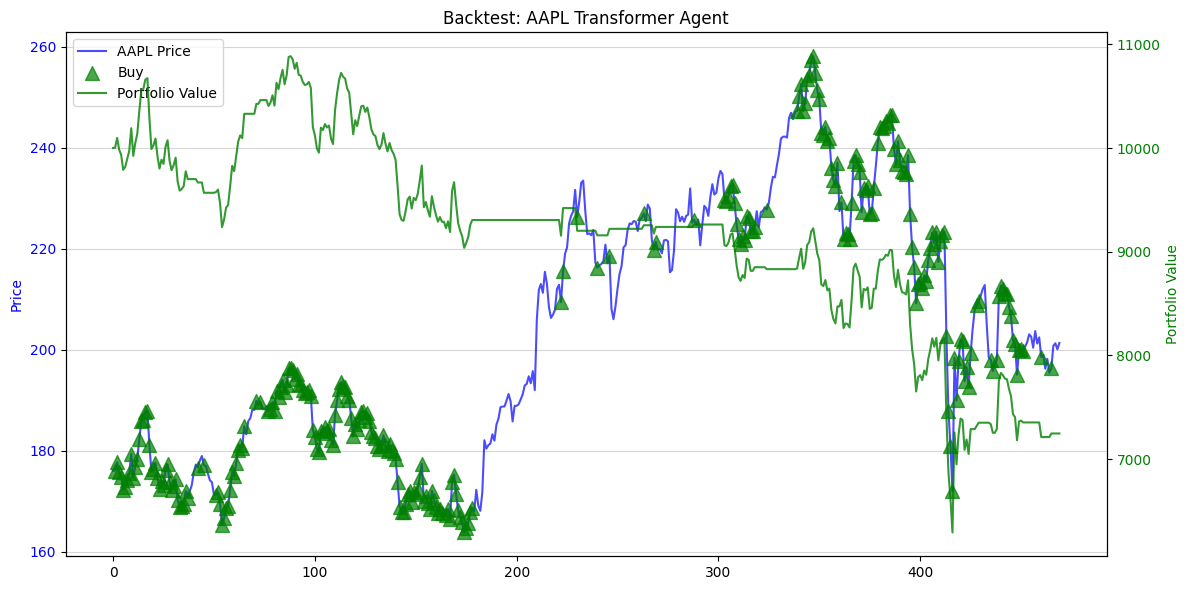

[06:46:24] ==== Running Transformer Backtest for MSFT ====
[06:46:25] [MSFT] Transformer Backtest Metrics:
[06:46:25] [MSFT] Total Return: 0.2542
[06:46:25] [MSFT] CAGR: 0.1294
[06:46:25] [MSFT] Annualized Volatility: 0.0886
[06:46:25] [MSFT] Sharpe Ratio: 1.3737
[06:46:25] [MSFT] Max Drawdown: 0.0575


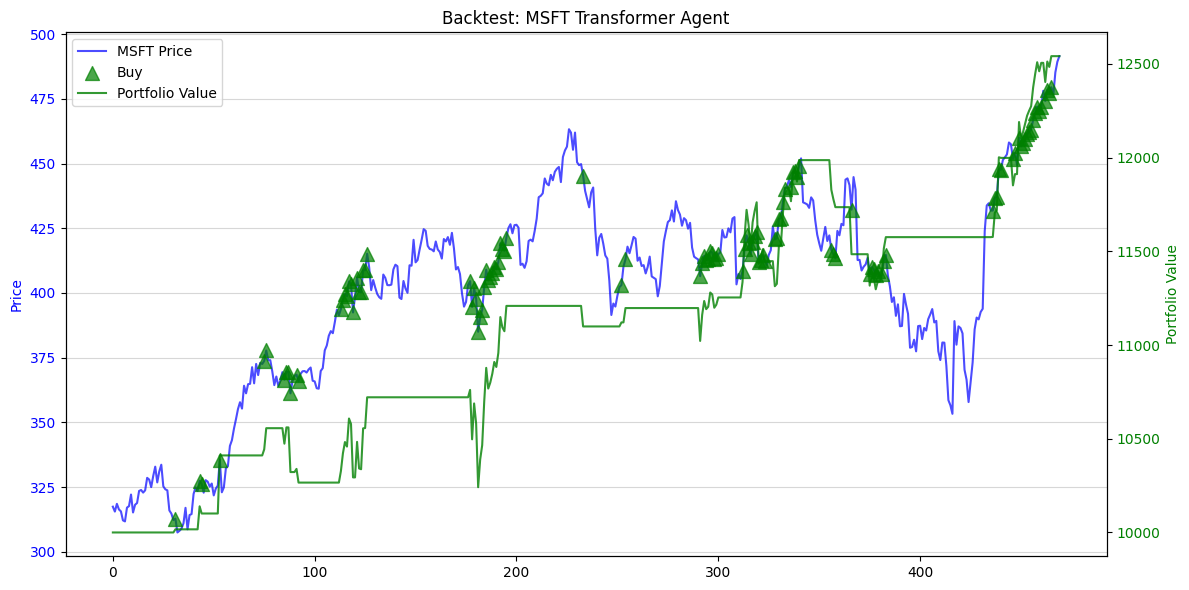

[06:46:26] ==== Running Transformer Backtest for GOOGL ====
[06:46:26] [GOOGL] Transformer Backtest Metrics:
[06:46:26] [GOOGL] Total Return: 0.7110
[06:46:26] [GOOGL] CAGR: 0.3345
[06:46:26] [GOOGL] Annualized Volatility: 0.1761
[06:46:26] [GOOGL] Sharpe Ratio: 1.6388
[06:46:26] [GOOGL] Max Drawdown: 0.1050


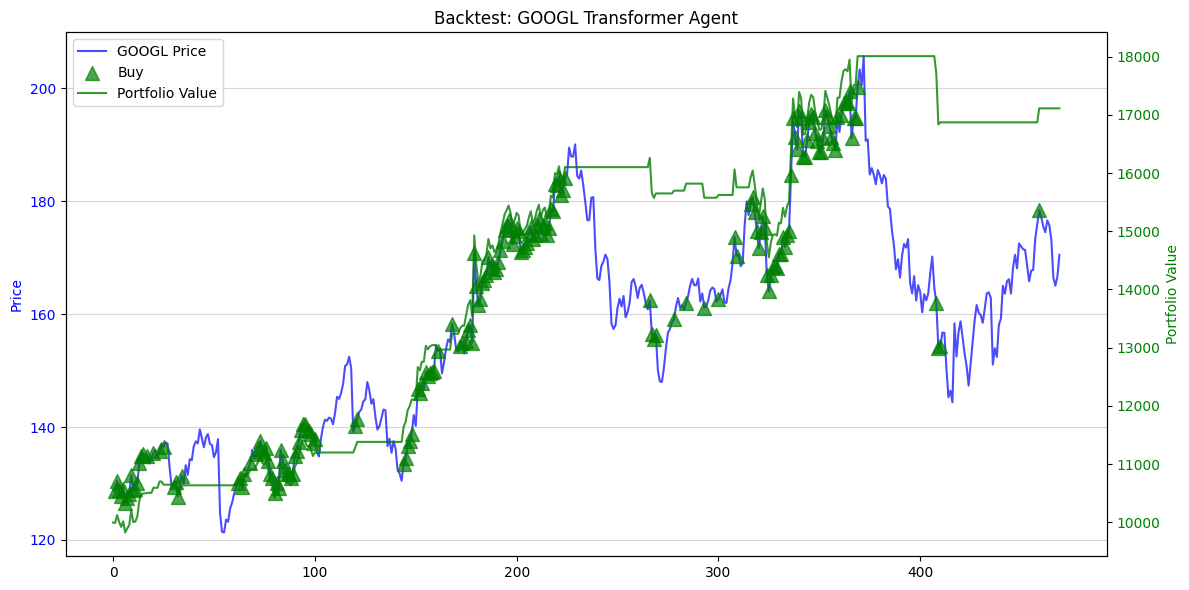

[06:46:28] ==== Transformer Backtests Completed for All Tickers (Simplified Env) ====


In [18]:
# Cell 7: Proper Transformer Backtest & Plot for Each Ticker (Simplified Env)

import os
import torch
import numpy as np
import pandas as pd
import gym
from gym import spaces # Import spaces
import matplotlib.pyplot as plt # Import matplotlib
import json # Import json

device = "cuda" if torch.cuda.is_available() else "cpu"

log("==== Starting Transformer Backtests (Simplified Env) ====")

# Define a simplified Trading Environment directly in this cell for backtesting
class SimplifiedTradingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, obs_test, rewards_test, seq_len, initial_cash=10000):
        super().__init__() # Correct super call

        self.obs_test = obs_test # (num_windows, seq_len, num_features)
        self.rewards_test = rewards_test # (num_windows,) - next day log returns
        self.seq_len = seq_len

        # Action space: 3 discrete (Hold, Buy, Sell) - matches Transformer output
        self.action_space = spaces.Discrete(3)

        # Observation space: matches the shape of a single window from obs_test
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.seq_len, self.obs_test.shape[-1]), dtype=np.float32)

        self.current_step = 0
        self.done = False
        self.cash = initial_cash
        self.portfolio_values = [self.cash]
        self.actions_taken = []


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.done = False
        self.cash = 10000 # Reset cash for each backtest run
        self.portfolio_values = [self.cash]
        self.actions_taken = []
        # Return the first observation window and info dict
        return self.obs_test[self.current_step], {}

    def step(self, action):
        if self.done:
            # Return zeros if episode is done
            return np.zeros_like(self.obs_test[0]), 0.0, True, False, {}

        # Map action to trading signal (-1 for Sell, 0 for Hold, 1 for Buy)
        position = {0: 0, 1: 1, 2: -1}[action]

        # Get the reward for the next day
        # The rewards_test array is aligned with the windows in obs_test
        reward = position * self.rewards_test[self.current_step]

        # Apply the reward (log return) to the cash
        self.cash = self.cash * np.exp(reward) # Assuming rewards are log returns

        self.portfolio_values.append(self.cash)
        self.actions_taken.append(action)

        self.current_step += 1

        # Check if the episode is done
        if self.current_step >= len(self.obs_test):
            self.done = True

        # Get the next observation
        next_state = self.obs_test[self.current_step] if not self.done else np.zeros_like(self.obs_test[0])

        info = {}
        terminated = self.done
        truncated = False # Assuming no truncation

        return next_state, reward, terminated, truncated, info

    def render(self, mode="human"):
        pass

# Helper function to calculate performance statistics
def perf_stats(equity_curve):
    equity_curve = np.maximum(equity_curve, 1e-9) # Avoid log(0) or log(negative)
    rets = np.diff(np.log(equity_curve))
    ann_mean = rets.mean() * 252 if len(rets) > 0 else 0
    ann_vol = rets.std() * np.sqrt(252) if len(rets) > 1 else 1e-8 # Avoid division by zero
    sharpe = ann_mean / (ann_vol + 1e-8) # Avoid division by zero
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / (peak + 1e-8) # Avoid division by zero
    mdd = drawdown.max()
    return {
        "CAGR": float(np.exp(ann_mean) - 1),
        "Vol": float(ann_vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd)
    }


# Modified backtest function to use the simplified environment
def run_transformer_backtest_simplified(obs_test, rewards_test, model, plot_prices, seq_len, initial_cash=10000):
    """
    Run backtest of Transformer agent on test data using the simplified environment.
    """
    env = SimplifiedTradingEnv(obs_test, rewards_test, seq_len, initial_cash=initial_cash)
    state, _ = env.reset()

    done = False

    # The loop structure is now handled within the environment's step implicitly
    # We just need to loop until the environment signals done
    while not done:
        # TransformerClassifier forward
        # Reshape the state to match the expected input shape (Batch, Sequence Length, Features)
        x = torch.tensor(state[None, ...], dtype=torch.float32).to(device)
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=-1)
            action = torch.argmax(probs, dim=-1).item()  # 0=Hold, 1=Buy, 2=Sell

        # Take a step in the environment with the chosen action
        state, reward, done, truncated, info = env.step(action)

    # The portfolio_values and actions_taken are collected within the environment
    return plot_prices, np.array(env.portfolio_values), env.actions_taken

# Reuse the existing plot_backtest function (Assuming it's defined elsewhere or above)
# If not defined, define it here:
def plot_backtest(prices, portfolio_values, actions_taken, ticker="AAPL"):
    """
    Plots price, portfolio value, and trading actions.
    """
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()

    # Plot Price
    ax1.plot(prices, label=f"{ticker} Price", color='blue', alpha=0.7)
    ax1.set_ylabel("Price", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(axis='y', alpha=0.5)

    # Plot Portfolio Value
    ax2 = ax1.twinx()
    ax2.plot(portfolio_values, label="Portfolio Value", color='green', alpha=0.8)
    ax2.set_ylabel("Portfolio Value", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Plot Actions (shifted to align with the day AFTER the action is taken)
    # actions_taken length is num_steps in backtest
    # portfolio_values length is num_steps + 1 (includes initial value)
    # Prices length is num_steps + 1 (aligned with portfolio values)
    action_indices = np.arange(len(actions_taken)) + 1 # Shift indices by 1

    buy_indices = [i for i, action in enumerate(actions_taken) if action == 1]
    sell_indices = [i for i, action in enumerate(actions_taken) if action == 2]

    # Plot Buy signals on the price chart (shifted)
    if buy_indices:
        ax1.scatter(np.array(buy_indices) + 1, prices[np.array(buy_indices) + 1],
                    marker='^', color='green', s=100, label='Buy', alpha=0.7, zorder=5)
    # Plot Sell signals on the price chart (shifted)
    if sell_indices:
        ax1.scatter(np.array(sell_indices) + 1, prices[np.array(sell_indices) + 1],
                    marker='v', color='red', s=100, label='Sell', alpha=0.7, zorder=5)


    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


    plt.title(f"Backtest: {ticker} Transformer Agent")
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/backtest_transformer_{ticker}.png", dpi=150)
    plt.show()


for ticker in CONFIG["tickers"]:
    log(f"==== Running Transformer Backtest for {ticker} ====")

    # Get test data from all_windows dictionary
    if ticker not in all_windows:
        log(f"[WARNING] No window data found for {ticker}, skipping backtest.")
        continue

    test_X = all_windows[ticker]["test_X"]
    test_df = all_windows[ticker]["test_df"].copy()

    # Rewards for the backtest are the NextLogRet values in the test_df
    if "NextLogRet" not in test_df.columns:
         log(f"[WARNING] 'NextLogRet' not found in test_df for {ticker}, skipping backtest.")
         continue
    rewards_test = test_df["NextLogRet"].values

    # Original prices for plotting should be the Close prices from the test_df,
    # plus one extra price for the day after the last action to show the final result.
    # The prices needed are from the start of the test_df index up to the end of test_df index + 1 day.
    # We need to get this from the *full* original dataframe for the ticker (all_data[ticker])
    df_t_full = all_data[ticker].copy()

    # Find the start and end locations of the test_df index in the full dataframe
    try:
        start_loc_in_full = df_t_full.index.get_loc(test_df.index[0])
        end_loc_in_full = df_t_full.index.get_loc(test_df.index[-1])

        # Prices needed for plotting are from the start of the test_df up to the day after the last day in test_df
        # The number of steps in the backtest is the number of windows in test_X.
        # The portfolio_values array will have num_windows + 1 elements.
        # The prices array for plotting should have the same length as portfolio_values.
        # This means we need the Close prices from the start of test_df until num_windows + 1 days.
        # The test_df has seq_len fewer rows than the original data used to create windows.
        # The test_X has num_test_samples = len(test_df) - seq_len + 1 windows.
        # The backtest runs for num_test_samples steps.
        # Portfolio value length is num_test_samples + 1.
        # Prices for plotting should cover the period corresponding to portfolio_values.
        # This is the period from the start of the first window in test_X until the end of the last step.
        # The first window starts at test_df.index[0]. The last step corresponds to the reward for the last window, which is on test_df.index[-1].
        # So, we need prices from test_df.index[0] up to test_df.index[-1]. Wait, the equity curve is one day longer.
        # The equity curve covers the period from the start of the backtest to the day AFTER the last action.
        # The actions are taken based on window i, and the reward is applied for day i+1.
        # The backtest loop runs for `len(obs_test)` steps. `obs_test` has `num_windows` rows.
        # The equity curve has `num_windows + 1` points.
        # The dates for these points are from `test_df.index[0]` to `test_df.index[num_windows]`.
        # The start date is test_df.index[0]. The number of points is `len(test_X) + 1`.
        # The end date should be `test_df.index[len(test_X)]`.

        # Let's get prices from the start of the test_df index up to len(test_X) days after that.
        # The test_X indices are 0 to len(test_X) - 1. These correspond to windows ending on
        # test_df.index[seq_len - 1] to test_df.index[len(test_df) - 1].
        # The rewards correspond to test_df.index[seq_len] to test_df.index[len(test_df)].
        # The backtest runs for len(test_X) steps.
        # The first price point corresponds to the start of the backtest (initial cash).
        # The backtest uses windows from test_X. test_X[0] is the first window.
        # The reward for test_X[0] is rewards_test[0], which is NextLogRet for test_df.index[seq_len].
        # The backtest starts with cash at test_df.index[seq_len-1]. The first action is taken then.
        # The first equity point is at test_df.index[seq_len-1]. The last equity point is at test_df.index[len(test_X) + seq_len - 1].
        # No, the env receives window i at step i, calculates reward for day i+1.
        # The backtest runs for len(obs_test) steps.
        # Step 0: env.step(action for window 0), reward for day 1, equity update for day 1.
        # Equity points are at day 0, day 1, ..., day len(obs_test).
        # Day 0 in the backtest corresponds to the start of the first window in obs_test.
        # So, prices should be from the start date of test_X[0] to the date of the last step's reward.
        # The date of the last step's reward is the date corresponding to rewards_test[-1].
        # rewards_test is aligned with test_X. So rewards_test[i] is the reward for day i+1 of the backtest.
        # The backtest dates run from the start of the first window (test_X[0]) until the day of the last reward (rewards_test[-1]).
        # The first window starts at test_df.index[0]. The rewards_test are aligned with test_df indices from `seq_len` onwards.
        # rewards_test[0] is for test_df.index[seq_len]. rewards_test[-1] is for test_df.index[len(test_df)-1].
        # The backtest starts at the date of the first window's end + 1 day = test_df.index[seq_len].
        # The backtest ends at the date of the last window's end + 1 day = test_df.index[len(test_df)].

        # Let's simplify: The backtest runs for `len(test_X)` steps.
        # The equity curve has `len(test_X) + 1` points.
        # The prices array needs to cover the same number of days.
        # The prices corresponding to the backtest are the Close prices from the start of the test data in df_t_full.
        # The test data starts at index `start_loc_in_full`.
        # We need `len(test_X) + 1` price points starting from `start_loc_in_full`.
        plot_prices = df_t_full["Close"].iloc[start_loc_in_full : start_loc_in_full + len(test_X) + 1].values


    except KeyError:
        log(f"[WARNING] Could not find index for {ticker} in original full dataframe for plotting.")
        continue
    except IndexError:
        log(f"[WARNING] Test dataframe is empty for {ticker}. Skipping backtest.")
        continue


    # Load Transformer model for this ticker
    model_path = f"{MODELS_DIR}/transformer_best_{ticker}.pt"
    if not os.path.exists(model_path):
        log(f"[WARNING] No saved transformer for {ticker}, skipping backtest.")
        continue

    # Instantiate model (ensure dimensions match training)
    meta_path = f"{MODELS_DIR}/meta_{ticker}.json"
    if os.path.exists(meta_path):
        with open(meta_path, 'r') as f:
            meta = json.load(f)
            n_features = len(meta.get("features", FEATURES))
            seq_len_meta = meta.get("seq_len", CONFIG["seq_len"])
    else:
         n_features = len(FEATURES)
         seq_len_meta = CONFIG["seq_len"]
         log(f"[WARNING] Metadata not found for {ticker}. Using default feature count ({n_features}) and seq_len ({seq_len_meta}).")


    # Re-define TransformerClassifier in this cell to ensure it's available
    class TransformerClassifier(nn.Module):
        def __init__(self, n_features, d_model, nhead, num_layers, dim_ff, dropout, seq_len):
            super().__init__()
            self.input_proj = nn.Linear(n_features, d_model)
            self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.01)
            enc_layer = nn.TransformerEncoderLayer(
                d_model, nhead, dim_ff, dropout, batch_first=True, norm_first=True
            )
            self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
            self.dropout = nn.Dropout(dropout)
            self.head = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_model // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, 2)   # binary classification: up/down
            )
        def forward(self, x):
            h = self.input_proj(x) + self.pos_emb[:, :x.size(1), :]
            h = self.encoder(h)
            h = self.dropout(h)
            out = self.head(h[:, -1, :])   # last token
            return out

    model = TransformerClassifier(
        n_features=n_features,
        d_model=CONFIG["transformer"]["d_model"],
        nhead=CONFIG["transformer"]["nhead"],
        num_layers=CONFIG["transformer"]["num_layers"],
        dim_ff=CONFIG["transformer"]["dim_feedforward"],
        dropout=CONFIG["transformer"]["dropout"], # Use dropout from CONFIG
        seq_len=seq_len_meta
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Run backtest using the simplified environment and function
    prices_ret, portfolio_values, actions_taken = run_transformer_backtest_simplified(
        test_X,
        rewards_test,
        model,
        plot_prices, # Pass the correctly aligned price data for plotting
        seq_len_meta, # Pass seq_len
        initial_cash=10000
    )

    # Calculate and print performance statistics
    if len(portfolio_values) > 1:
        backtest_stats = perf_stats(portfolio_values)
        log(f"[{ticker}] Transformer Backtest Metrics:")
        log(f"[{ticker}] Total Return: {(portfolio_values[-1] / portfolio_values[0] - 1):.4f}")
        log(f"[{ticker}] CAGR: {backtest_stats['CAGR']:.4f}")
        log(f"[{ticker}] Annualized Volatility: {backtest_stats['Vol']:.4f}")
        log(f"[{ticker}] Sharpe Ratio: {backtest_stats['Sharpe']:.4f}")
        log(f"[{ticker}] Max Drawdown: {backtest_stats['MaxDD']:.4f}")
    else:
        log(f"[{ticker}] Not enough steps in backtest for metric calculation.")


    # Plot results
    plot_backtest(prices_ret, portfolio_values, actions_taken, ticker=ticker)

log("==== Transformer Backtests Completed for All Tickers (Simplified Env) ====")

# Cell: Transformer Inference & PPO Signal Mapping

This cell performs inference using trained Transformer models for each ticker, predicts the next-day log return, and maps it to a PPO trading action.

**Steps:**

1. **Setup**
   - Import libraries (`torch`, `joblib`, `sklearn.preprocessing`, `json`).
   - Set device (`cuda` if available).
   - Initialize `all_artifacts` dictionary.

2. **Data Preparation**
   - Load feature dataframe `df_feat` for the ticker.
   - Fit and save a `StandardScaler` on the selected features.
   - Extract the last sequence window (`last_win`) for prediction.

3. **Load Transformer Model**
   - Load the saved model weights (`transformer_best_{ticker}.pt`).
   - Initialize `TransformerClassifier` with training hyperparameters.
   - Set model to evaluation mode.

4. **Next-Day Prediction**
   - Convert `last_win` to a Torch tensor.
   - Predict the next-day log return (`pred_next_logret`).

5. **Map Prediction to PPO Action**
   - If `pred_next_logret > 0` → Buy (`ppo_action=1`, signal="BUY")
   - If `pred_next_logret < 0` → Sell (`ppo_action=2`, signal="SELL")
   - If `pred_next_logret == 0` → Hold (`ppo_action=0`, signal="HOLD")

6. **Save Artifacts**
   - Store paths to Transformer weights and scaler.
   - Store latest prediction, PPO action, and signal in `all_artifacts`.

7. **Output**
   - Pretty print all ticker signals as JSON for inspection.


In [19]:
import torch
import json
import os
import joblib
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

all_artifacts = {}

for ticker in CONFIG["tickers"]:
    print(f"\n[INFO] Processing inference for {ticker}...")

    df_feat = all_data[ticker]

    # Fit and save scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_feat[FEATURES].values)

    scaler_path = f"{MODELS_DIR}/scaler_{ticker}.pkl"
    joblib.dump(scaler, scaler_path)
    print(f"[INFO] Saved scaler for {ticker} at {scaler_path}")

    # Last window for prediction
    last_win = X_scaled[-seq_len:]

    # Load Transformer model
    model_path = f"{MODELS_DIR}/transformer_best_{ticker}.pt"
    if not os.path.exists(model_path):
        print(f"[WARNING] No saved transformer for {ticker}, skipping...")
        continue

    model = TransformerClassifier(
        n_features=len(FEATURES),
        d_model=CONFIG["transformer"]["d_model"],
        nhead=CONFIG["transformer"]["nhead"],
        num_layers=CONFIG["transformer"]["num_layers"],
        dim_ff=CONFIG["transformer"]["dim_feedforward"],
        dropout=CONFIG["transformer"]["dropout"],
        seq_len=seq_len
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Predict next log return
    with torch.no_grad():
        x = torch.tensor(last_win[None, ...], dtype=next(model.parameters()).dtype).to(device)
        pred_next_logret = float(model(x).cpu().numpy().ravel()[0])

    # Map to PPO action
    if pred_next_logret > 0:
        ppo_action = 1  # Buy / Long
        signal = "BUY"
    elif pred_next_logret < 0:
        ppo_action = 2  # Sell / Short
        signal = "SELL"
    else:
        ppo_action = 0  # Hold
        signal = "HOLD"

    # Save artifacts
    all_artifacts[ticker] = {
        "transformer_weights": model_path,
        "scaler": scaler_path,
        "latest_signal": {
            "pred_next_logret": pred_next_logret,
            "ppo_action": ppo_action,
            "signal": signal
        }
    }

# Pretty print all ticker signals
print(json.dumps(all_artifacts, indent=2))



[INFO] Processing inference for AAPL...
[INFO] Saved scaler for AAPL at /content/drive/MyDrive/stock_rl_transformer/models/scaler_AAPL.pkl

[INFO] Processing inference for MSFT...
[INFO] Saved scaler for MSFT at /content/drive/MyDrive/stock_rl_transformer/models/scaler_MSFT.pkl

[INFO] Processing inference for GOOGL...
[INFO] Saved scaler for GOOGL at /content/drive/MyDrive/stock_rl_transformer/models/scaler_GOOGL.pkl
{
  "AAPL": {
    "transformer_weights": "/content/drive/MyDrive/stock_rl_transformer/models/transformer_best_AAPL.pt",
    "scaler": "/content/drive/MyDrive/stock_rl_transformer/models/scaler_AAPL.pkl",
    "latest_signal": {
      "pred_next_logret": -0.018748361617326736,
      "ppo_action": 2,
      "signal": "SELL"
    }
  },
  "MSFT": {
    "transformer_weights": "/content/drive/MyDrive/stock_rl_transformer/models/transformer_best_MSFT.pt",
    "scaler": "/content/drive/MyDrive/stock_rl_transformer/models/scaler_MSFT.pkl",
    "latest_signal": {
      "pred_next_lo

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
